# Trabajo Práctico 1 
### Clasificación sobre datos simulados. 

## Introducción
Para este trabajo, hemos creado una función generadora de minions. Sobre cada minion, hemos medido 200 características que representan habilidades que poseen en distintas tareas (relacionadas al Mal).  

El doctor Nefario ha ideado una fórmula para determinar si un minion es o no apto para concretar su plan para conquistar el mundo. De esta manera ha etiquetado más de 500 minions. Lamentablemente, ha perdido dicha fórmula y necesita seguir decidiendo si nuevos minions son o no aptos para su macabro plan.

Es por esto que nuestro objetivo será construir clasificadores que estimen lo mejor posible la probabilidad de que nuevos minions sean o no aptos para concretar el plan de conquista y así facilitarle las cosas al doctor Nefario.

Por otra parte, ya que el doctor Nefario tuvo problemas con equipos que sobreestiman sus resultados, decidió guardarse varias etiquetas extra que no compartirá con nadie, y que luego utilizará para elegir al mejor equipo, al cual contratará para (de una vez por todas) conquistar el mundo. 


En concreto:

Tendrán disponible una matriz de datos $X$ de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$. Además, tendrán y, un vector de $500$ posiciones con dos posibles valores: $True$ y $False$. 

Por otra parte, tendrán disponibles más instancias de evaluación $X_{competencia}$ sin las respectivas etiquetas que utilizaremos para evaluar sus resultados. 



In [1]:
# PREAMBULOS
%matplotlib inline

SEED = 1234

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML
from time import time

import numpy as np
np.set_printoptions(precision=4)
np.random.seed(SEED)

import pandas as  pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)

pd.set_option('precision', 4)

import matplotlib.pyplot as plt

import seaborn as sns

import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.svm

import sklearn.model_selection
from scipy.stats import randint as sp_randint

In [2]:
# Carga de datos
X = pd.read_csv("X.csv", index_col="index")
y = pd.read_csv("y.csv", index_col="index", dtype=int)  # Cargamos los valores booleanos (True y False)
                                                        # como números (1 y 0) para facilitar el manejo luego. 

#display(X)
#display(y)

#Datos de competencia
#X_competencia = pd.read_csv("X_competencia.csv", index_col="index")
#y_competencia_ejemplo = pd.read_csv("y_competencia_ejemplo.csv", index_col="index")

# Descomentar si quieren ver los datos para la competencia:
# display(X_competencia) 
# display(y_competencia_ejemplo)

## Ejercicio 1

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. En este punto pedimos que evalúen cómo separar sus datos para desarrollo y para evaluación tomando en cuenta la competencia. 

Se seleccionaron 450 instancias para desarrollo y 50 instancias para evaluación

Distribución original


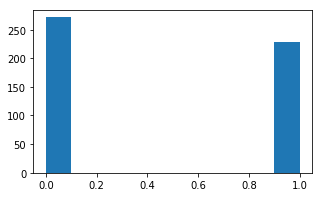

Distribución de los datos de entrenamiento


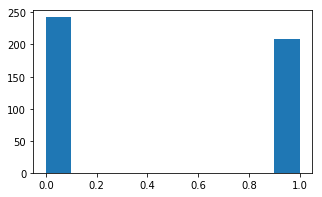

In [3]:
# EJERCICIO 1. 

porcentaje_eval = 0.1
X_dev, X_eval, y_dev, y_eval = sklearn.model_selection.train_test_split(X, y, test_size=porcentaje_eval)

print("Se seleccionaron {} instancias para desarrollo y {} instancias para evaluación".format(len(X_dev), len(X_eval)))
print("")

print("Distribución original")
plt.figure(figsize=(5, 3))
plt.hist(np.array(y))
plt.show()

print("Distribución de los datos de entrenamiento")
plt.figure(figsize=(5, 3))
plt.hist(np.array(y_dev)) 
plt.show()



## Ejercicio 2

### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión, de manera de obtener una estimación realista de la performance de los mismos. 

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. 
2. Estimar la performance del modelo utilizando K-fold cross validation con K = 5, con las métricas “Accuracy” y “ROC AUC”. Para ello, se pide medir la performance en cada partición tanto sobre el fold de validación como sobre los folds de entrenamiento. Luego, completar la primera tabla.
3. Entrenar árboles de decisión para cada una de las siguientes combinaciones y completar la segunda tabla.

----

**EJERCICIO EXTRA: Usar la implementación de árboles de decisión que realizaron para la guía de ejercicios de la materia. Adaptarla para que cumpla con la interfaz requerida por sklearn, asegurarse de que funcione con variables continuas y reproducir las tablas anteriores.   **

----

,Accuracy (training),Accuracy (validación),AUC ROC (training),AUC ROC (validación)
Permutación,,,,
1,0.8167,0.6556,0.8737,0.6892
2,0.8278,0.6111,0.8878,0.6410
3,0.8222,0.7111,0.8739,0.7523
4,0.8361,0.7111,0.8543,0.7456
5,0.8056,0.7444,0.8822,0.7566


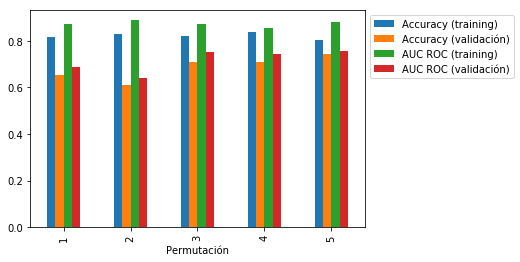

In [4]:
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# Numpy arrays con los datos de desarrollo (obligatorio para las funciones de folding)
X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()

# INPUT: un clasificador que será entrenado y evaluado
# OUTPUT: evaluaciones: 4 arrays, donde cada posición corresponde a los valores de un fold. 
# Los 4 arrays son: accuracy_train, accuracy_test, roc_score_train, roc_score_test
def TrainAndEvaluate(clf, ResultProba=True, MaxDevSize=None):
    # Inicializamos los arrays resultado:
    accuracies_training = []
    accuracies_validation = []
    aucs_training = []
    aucs_validation = []

    # Particionamos el espacio en 5 folds:
    cantidad_particiones = 5
    kf = sklearn.model_selection.KFold(n_splits=cantidad_particiones, shuffle=False, random_state=None)

    # Copiamos el espacio dev
    if MaxDevSize == None:
        temp_X_dev_np = X_dev_np
        temp_y_dev_np = y_dev_np
    else:
        temp_X_dev_np = X_dev_np[0:min(MaxDevSize, len(X_dev_np))]
        temp_y_dev_np = y_dev_np[0:min(MaxDevSize, len(y_dev_np))]
    
    # Para cada partición, entrenamos y evaluamos
    i = 1
    for train_index, test_index in kf.split(temp_X_dev_np,temp_y_dev_np):
        X_train, X_test = X_dev_np[train_index], X_dev_np[test_index]
        y_train, y_test = y_dev_np[train_index], y_dev_np[test_index]
        # Entrenamos:
        clf = clf.fit(X_train, y_train)
        # Predecimos: A) sobre el training, B) sobre el evaluado
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)
        # Evaluamos accuracy
        acc_train = accuracy_score(y_train, y_train_predict)
        acc_test = accuracy_score(y_test, y_test_predict)
        # Predecimos con probabilidad y luego calculamos ROC AUC
        # Por cada valor de Y se devuelve la probabilidad de ser 0 y la de ser 1, nos quedamos con la de ser 1
        if ResultProba:
            y_train_predict_proba = clf.predict_proba(X_train)[:,1]
            y_test_predict_proba = clf.predict_proba(X_test)[:,1]
        else:
            y_train_predict_proba = clf.predict(X_train)
            y_test_predict_proba = clf.predict(X_test)
        # Evaluamos ROC AUC
        roc_train = roc_auc_score(y_train, y_train_predict_proba)
        roc_test = roc_auc_score(y_test, y_test_predict_proba)
        # Agregamos los resultados a los arrays correspondientes
        accuracies_training.append(acc_train)
        accuracies_validation.append(acc_test)
        aucs_training.append(roc_train)
        aucs_validation.append(roc_test)
        # Mostramos los resultados
        #print("FOLD: {}".format(i))
        #print("ACC. TRAIN: {}".format(acc_train))
        #print("ACC. TEST: {}".format(acc_test))
        #print("ROC TRAIN: {}".format(roc_train))
        #print("ROC TEST: {}".format(roc_test))
        i = i+1
    return accuracies_training, accuracies_validation, aucs_training, aucs_validation
    
# INPUT: altura máxima del árbol (o None si es infinito), criterio de selección (gini o entropy)
# OUTPUT: 4 arrays, donde cada posición corresponde a los valores de un fold. 
# Los 4 arrays son: accuracy_train, accuracy_test, roc_score_train, roc_score_test
def BuildAndEvaluateTree(max_depth, criterion, MaxDevSize=None):
    return TrainAndEvaluate(tree.DecisionTreeClassifier(max_depth=max_depth, criterion=criterion), MaxDevSize=MaxDevSize)

accuracies_training, accuracies_validation, aucs_training, aucs_validation = BuildAndEvaluateTree(3, "gini")

df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
df["Accuracy (training)"] = accuracies_training
df["Accuracy (validación)"] = accuracies_validation
df["AUC ROC (training)"] = aucs_training
df["AUC ROC (validación)"] = aucs_validation

display(HTML("<h3> TABLA 1 </h3>"))
display(df)

# Graficar el resultado
df.plot(kind="bar")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

In [5]:
resultados_training = []
resultados_validation = []

for criterio in ["gini", "entropy"]:
    for altura in [3, 5, None]:
        accuracies_training, accuracies_validation, aucs_training, aucs_validation = BuildAndEvaluateTree(altura, criterio)
        promedio_roc_training = np.array(aucs_training).mean()
        promedio_roc_test = np.array(aucs_validation).mean()
        resultados_training.append(promedio_roc_training)
        resultados_validation.append(promedio_roc_test)

df = pd.DataFrame(index=range(0,6))
df["Altura máxima"] = [3, 5, "Inifinito"] * 2
df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
df["AUC ROC promedio (training)"] = resultados_training
df["AUC ROC promedio (validación)"] = resultados_validation

display(HTML("<h3> TABLA 2 </h3>"))
display(df)

,Altura máxima,Criterio de evaluación de corte,AUC ROC promedio (training),AUC ROC promedio (validación)
0,3,Gini,0.8744,0.7169
1,5,Gini,0.9754,0.6530
2,Inifinito,Gini,1.0000,0.6287
3,3,Ganancia de Información,0.8772,0.7153
4,5,Ganancia de Información,0.9823,0.6927
5,Inifinito,Ganancia de Información,1.0000,0.7081


## Ejercicio 3: Comparación de algoritmos


Se pide explorar distintas combinaciones de algoritmos de aprendizaje e hiperparámetros, de manera de buscar una performance óptima. Para este ejercicio es necesario que evalúen posibilidades utilizando la técnica de Grid Search. Como métrica de performance, usar siempre el área bajo la curva (AUC ROC) resultante de 5-fold cross-validation. 

Algoritmos a probar: KNN, árboles de decisión, LDA, Naive Bayes y SVM. Hiperparámetros: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras.  

Se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

En este punto evaluaremos tanto los hiperparámetros elegidos como las conclusiones relacionadas a por qué piensan que ciertos algoritmos funcionan mejor que otros para estos datos. 



----

**EJERCICIO EXTRA**: Utilizar RandomizedSearchCV con rangos de parámetros que contengan a los utilizados en el GridSearch. Analizar si se encontraron mejores combinaciones de parámetros que no hayan sido tenidas en cuenta con el GridSearch y cuál fue la diferencia de tiempo de ejecución. 

----

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# Función de impresión
def top_resultados(grid, top=5):
    print("Top {} combinaciones".format(top))
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    display(df.sort_values(by="mean_score_validation", ascending=False).head(top))

def evaluar_clasificador(nombre, clasificador, params, sampleador=GridSearchCV):
    grd_clasificador = sampleador(clasificador, params, cv=5)
    grd_clasificador.fit(X_dev_np, y_dev_np)
    print(nombre)
    print("Los mejores parámetros son: {}".format(grd_clasificador.best_params_))
    top_resultados(grd_clasificador)

# VAMOS ALGORITMO POR ALGORITMO:

#KNN
# Parámetros: 
# 1) Cantidad de vecinos (n_neighbors = int)
# 2) Peso: uniforme/según distancia (weights = uniform/distance)
# 3) algoritmo (auto, ball_tree,  kd_tree, brute) (TODO: ver que es cada uno)
parameters = {'weights':('uniform', 'distance'), 'n_neighbors':[1, 5, 10, 20, 50]}
clf_knn = KNeighborsClassifier()
evaluar_clasificador("KNN", clf_knn, parameters)

#DecisionTree
# Parámetros
# 1) Altura máxima
# 2) Criterio de selección de nodos (gini o entropy)
parameters = {'criterion':('gini', 'entropy'), 'max_depth':[None, 3, 5]}
clf_dec_tree = DecisionTreeClassifier()
evaluar_clasificador("Decision Tree", clf_dec_tree, parameters)

#LDA
# No conozco los parámetros... (TODO: ver que onda)
parameters = { }
clf_lda = LinearDiscriminantAnalysis()
evaluar_clasificador("LDA", clf_lda, parameters)

#Naive Bayes
# No conozco los parámetros... (TODO: ver que onda)
parameters = { }
clf_gaussian_nb = GaussianNB()
evaluar_clasificador("Naive Bayes", clf_gaussian_nb, parameters)

#SVM
# Parámetros
# 1) Kernel (linear, polynomial, rbf (radial), sigmoid) (algunos de estos kernel llevan parámetros especiales que asumo default)
# 2) C (si es chico puede ajustar mejor pero puede cometer más errores de clasificación)
parameters = {'kernel':('linear', 'rbf', 'sigmoid'), 'C':[1, 5, 10]}
clf_svm = svm.SVC()
evaluar_clasificador("SVM", clf_svm, parameters)

KNN
Los mejores parámetros son: {'n_neighbors': 50, 'weights': 'uniform'}
Top 5 combinaciones


/usr/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,n_neighbors,weights,mean_score_training,mean_score_validation
8,50,uniform,0.7784,0.7667
6,20,uniform,0.7867,0.7622
9,50,distance,1.0000,0.7600
7,20,distance,1.0000,0.7489
5,10,distance,1.0000,0.7378


Decision Tree
Los mejores parámetros son: {'criterion': 'gini', 'max_depth': 3}
Top 5 combinaciones


/usr/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,criterion,max_depth,mean_score_training,mean_score_validation
1,gini,3.0,0.8267,0.6644
4,entropy,3.0,0.8073,0.6622
0,gini,NaN,1.0000,0.6533
5,entropy,5.0,0.9139,0.6511
2,gini,5.0,0.9439,0.6489


LDA
Los mejores parámetros son: {}
Top 5 combinaciones


/usr/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,mean_score_training,mean_score_validation
0,0.965,0.6711


Naive Bayes
Los mejores parámetros son: {}
Top 5 combinaciones


/usr/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,mean_score_training,mean_score_validation
0,0.7722,0.7289


SVM
Los mejores parámetros son: {'C': 5, 'kernel': 'rbf'}
Top 5 combinaciones


/usr/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,C,kernel,mean_score_training,mean_score_validation
4,5,rbf,1.0000,0.7756
7,10,rbf,1.0000,0.7756
1,1,rbf,0.9878,0.7644
2,1,sigmoid,0.8584,0.7644
5,5,sigmoid,0.8317,0.7600


#### Conclusiones Grid Search

TODO

## Ejercicio 4: 
### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----




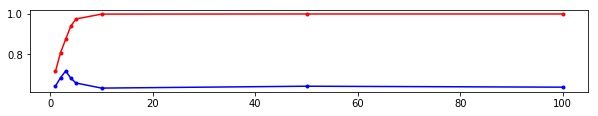

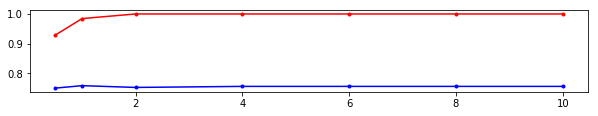

In [7]:
# Curvas de complejidad
# Decision Tree
resultados_training_tree = []
resultados_validation_tree = []

alturas_max = [1, 2, 3, 4, 5, 10, 50, 100]
for altura in alturas_max:
    accuracies_training, accuracies_validation, aucs_training, aucs_validation = BuildAndEvaluateTree(altura, "gini")
    promedio_roc_training = np.array(aucs_training).mean()
    promedio_roc_test = np.array(aucs_validation).mean()
    resultados_training_tree.append(promedio_roc_training)
    resultados_validation_tree.append(promedio_roc_test)

plt.figure(figsize=(10, 1.5))
plt.plot(alturas_max, resultados_training_tree, ".-", color="red")
plt.plot(alturas_max, resultados_validation_tree, ".-", color="blue")

#SVM 
# Utiliza la función del ejercicio 1 TrainAndEvaluate
def BuildAndEvaluateSVM(C, kernel, MaxDevSize=None):
    return TrainAndEvaluate(svm.SVC(C=C, kernel=kernel), ResultProba = False, MaxDevSize = MaxDevSize)

resultados_training_svm = []
resultados_validation_svm = []

params_C = [0.5, 1, 2, 4, 6, 8, 10]
for C in params_C:
    accuracies_training, accuracies_validation, aucs_training, aucs_validation = BuildAndEvaluateSVM(C, "rbf")
    promedio_roc_training = np.array(aucs_training).mean()
    promedio_roc_test = np.array(aucs_validation).mean()
    resultados_training_svm.append(promedio_roc_training)
    resultados_validation_svm.append(promedio_roc_test)

plt.figure(figsize=(10, 1.5))
plt.plot(params_C, resultados_training_svm, ".-", color="red")
plt.plot(params_C, resultados_validation_svm, ".-", color="blue")

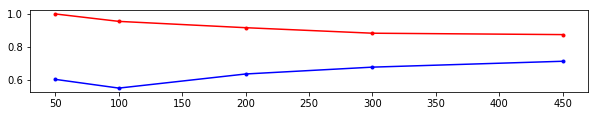

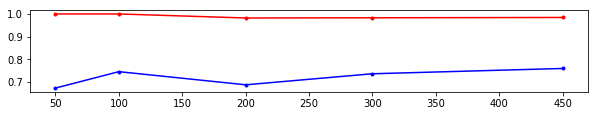

In [8]:
#Curvas de aprendizaje
# Decision Tree
resultados_training_tree = []
resultados_validation_tree = []

max_dev_sizes = [50, 100, 200, 300, 450]
for max_size in max_dev_sizes:
    accuracies_training, accuracies_validation, aucs_training, aucs_validation = BuildAndEvaluateTree(3, "gini", MaxDevSize=max_size)
    promedio_roc_training = np.array(aucs_training).mean()
    promedio_roc_test = np.array(aucs_validation).mean()
    resultados_training_tree.append(promedio_roc_training)
    resultados_validation_tree.append(promedio_roc_test)

plt.figure(figsize=(10, 1.5))
plt.plot(max_dev_sizes, resultados_training_tree, ".-", color="red")
plt.plot(max_dev_sizes, resultados_validation_tree, ".-", color="blue")

#SVM 
resultados_training_svm = []
resultados_validation_svm = []

max_dev_sizes = [50, 100, 200, 300, 450]
for max_size in max_dev_sizes:
    accuracies_training, accuracies_validation, aucs_training, aucs_validation = BuildAndEvaluateSVM(1, "rbf", MaxDevSize=max_size)
    promedio_roc_training = np.array(aucs_training).mean()
    promedio_roc_test = np.array(aucs_validation).mean()
    resultados_training_svm.append(promedio_roc_training)
    resultados_validation_svm.append(promedio_roc_test)

plt.figure(figsize=(10, 1.5))
plt.plot(max_dev_sizes, resultados_training_svm, ".-", color="red")
plt.plot(max_dev_sizes, resultados_validation_svm, ".-", color="blue")

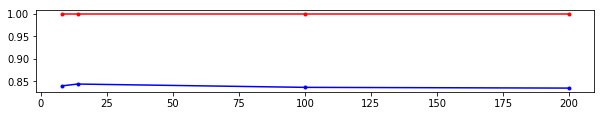

In [9]:
from sklearn.ensemble import RandomForestClassifier

# RANDOM FOREST
# Utiliza la función del ejercicio 1 TrainAndEvaluate. Clavo algunos parámetros de construcción que no vamos a variar
def BuildAndEvaluateRandomForest(max_features, MaxDevSize=None):
    return TrainAndEvaluate(RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=None, max_features=max_features), MaxDevSize = MaxDevSize)

# El hiperparámetro max_features determina la cantidad máxima de features a utilizar en cada nodo. Valores posibles:
# If int, then consider max_features features at each split.
# If float, then max_features is a fraction and int(max_features * n_features) features are considered at each split.
# If “auto”, then max_features=sqrt(n_features).
# If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
# If “log2”, then max_features=log2(n_features).
# If None, then max_features=n_features

# CURVA DE COMPLEJIDAD
# Para poder hacer mejor la curva de complejidad, utilizaré valores enteros, sabiendo que hay 200 atributos tenemos que:
# 8 = LOG_2(200)
# 14 = SQRT(200)
# 100 = N/2
# 200 = N

resultados_training_mf_rf = []
resultados_validation_mf_rf = []

max_features = [8, 14, 100, 200]
for mf in max_features:
    accuracies_training, accuracies_validation, aucs_training, aucs_validation = BuildAndEvaluateRandomForest(mf)
    promedio_roc_training = np.array(aucs_training).mean()
    promedio_roc_test = np.array(aucs_validation).mean()
    resultados_training_mf_rf.append(promedio_roc_training)
    resultados_validation_mf_rf.append(promedio_roc_test)

plt.figure(figsize=(10, 1.5))
plt.plot(max_features, resultados_training_mf_rf, ".-", color="red")
plt.plot(max_features, resultados_validation_mf_rf, ".-", color="blue")


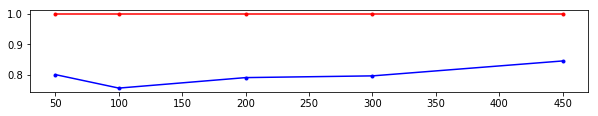

In [10]:
# CURVA DE APRENDIZAJE. Tomamos hiperparámetro fijo max_features = SQRT(n) = SQRT(200) = 14

resultados_training_rf = []
resultados_validation_rf = []

max_dev_sizes = [50, 100, 200, 300, 450]
for max_size in max_dev_sizes:
    accuracies_training, accuracies_validation, aucs_training, aucs_validation = BuildAndEvaluateRandomForest(14, MaxDevSize=max_size)
    promedio_roc_training = np.array(aucs_training).mean()
    promedio_roc_test = np.array(aucs_validation).mean()
    resultados_training_rf.append(promedio_roc_training)
    resultados_validation_rf.append(promedio_roc_test)

plt.figure(figsize=(10, 1.5))
plt.plot(max_dev_sizes, resultados_training_rf, ".-", color="red")
plt.plot(max_dev_sizes, resultados_validation_rf, ".-", color="blue")

In [26]:


params = {'loss': ['deviance', 'exponential'],
         'n_estimators': [1, 10, 100, 1000],
         'learning_rate': [0.01, 0.1, 0.5, 1],
         'criterion': ['friedman_mse', 'mse'],
         'max_depth': list(range(1,10)) + list(range(20, 100, 10)) + list(range(200, 1000, 100)) + [None],
         #max_features, reduce varianza aumenta sesgo
         'min_samples_leaf': [1, 5, 10, 50]
         # El resto que lei me parecen redundantes con estos.
         }

clf_gb = sklearn.ensemble.GradientBoostingClassifier()

# copy pasteo la funcion evaluar clasificador porque necesito tocar n_iter.
rnd_clasificador = sklearn.model_selection.RandomizedSearchCV(clf_gb, params, cv=5, n_iter=50)
rnd_clasificador.fit(X_dev_np, y_dev_np)
print("Gradient Boosting")
print("Los mejores parámetros son: {}".format(rnd_clasificador.best_params_))
top_resultados(rnd_clasificador)

# Mejor friedman_mse 0.5 exponential 7.0 50 1000 1.0 0.7756

/usr/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Gradient Boosting
Los mejores parámetros son: {'n_estimators': 1000, 'min_samples_leaf': 50, 'max_depth': 7, 'loss': 'exponential', 'learning_rate': 0.5, 'criterion': 'friedman_mse'}
Top 5 combinaciones


,criterion,learning_rate,loss,max_depth,min_samples_leaf,n_estimators,mean_score_training,mean_score_validation
39,friedman_mse,0.5,exponential,7.0,50,1000,1.0,0.7756
41,mse,1.0,exponential,80.0,10,100,1.0,0.7689
22,mse,0.1,deviance,7.0,50,1000,1.0,0.7667
42,mse,0.1,exponential,40.0,10,1000,1.0,0.7667
16,mse,0.5,exponential,30.0,50,100,1.0,0.7644


## Competencias

La entrega del trabajo estará acompañada de una competencia en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

Su tarea será estimar la performance (AUC ROC) que tendrá su mejor modelo en datos de evaluación (X_competencia). 

Para ello, deberán predecir las probabilidades de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUC ROC resultante y calcularemos el resultado real. El grupo que consiga acercarse más al valor real, será el grupo ganador.  

Recomendamos no perder de vista esta competencia en el momento de separar los datos en los primeros puntos. 

Para esto, junto con la entrega del informe, deberán enviar un archivo en formato csv con las columnas “index” y “output” (ver ejemplo de archivo en: [y_competencia_ejemplo.csv](https://github.com/pbrusco/aa-notebooks/blob/master/TP1/y_competencia_ejemplo.csv)) y un valor esperado de AUC ROC. 


## Entrega
- Contarán con un esqueleto en formato Jupyter Notebook en donde tendrán que completar las celdas faltantes (ya sea con explicaciones y gráficos o código). 
- El notebook final deberá ser entregado en formatos .html e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (Kernel - Restart and Run All) utilizando las bibliotecas requeridas en el archivo: requirements.txt del repositorio. 
- Tienen tiempo hasta las 23:59hs del día miércoles 17/10/2018. La entrega se debe realizar a través del campus virtual y debe contener el informe.
- El trabajo deberá elaborarse en grupos de 3 personas.
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.
- En el primer parcial se incluirá una pregunta sobre la solución entregada. Esa pregunta no influirá en la nota del parcial, pero sí en la nota individual del TP1.
- La participación en la competencia es obligatoria. De todas maneras, el resultado no incidirán en la nota de la materia.
- Los ejercicios extra son opcionales para aprobar el TP, pero son obligatorios para promocionar la materia.
